In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, LSTM, Activation, Dropout, Dense

Using TensorFlow backend.


## IMPORT DATA

In [7]:
df_tess = pd.read_csv('data/tess.csv')
df_radvess = pd.read_csv('data/radvess.csv')
df_savee = pd.read_csv('data/savee.csv')

In [8]:
df_tess['gender'] = 'female'
df_savee['gender'] = 'male'

In [12]:
def gender(x):
    if int(x[35:-4]) % 2 == 0:
        return 'female'
    else:
        return 'male'
df_radvess['gender'] = df_radvess['filename'].apply(lambda x: gender(x))

In [16]:
from src.clean_data import clean_radvess, clean_tess, clean_savee

df_tess = clean_tess(df_tess)
df_radvess = clean_radvess(df_radvess)
df_savee = clean_savee(df_savee)

In [17]:
df = pd.concat([df_tess, df_radvess, df_savee], axis=0)

In [19]:
def uniform_emotion(x):
    emotion_dict = {'fear' : 'fearful', 'ps' : 'surprised', 'calm' : 'neutral'}
    if x in emotion_dict:
        return emotion_dict[x]
    else: return x

df['emotion'] = df['emotion'].apply(lambda x: uniform_emotion(x))
df = df[df['emotion'].notnull()]

emotional_decrease = {'neutral' : 'neutral', 'calm' : 'neutral', 'happy' : 'positive', 'sad' : 'negative', 'angry' : 'negative', 'fearful' : 'negative', 'disgust' : 'negative', 'surprised' : 'surprised'}

df['emotion'] = df['emotion'].apply(lambda x: emotional_decrease[x])
df = df[df['emotion'] != 'surprised']

In [20]:
df['emotion'] = df['gender'] + '_' + df['emotion']
df = df.drop(columns='gender')

## CREATE X AND Y

In [21]:
emotion = df['emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)

In [22]:
# df.groupby(emotion).count()

In [23]:
encoder.inverse_transform(np.unique(y))

array(['female_negative', 'female_neutral', 'female_positive',
       'male_negative', 'male_neutral', 'male_positive'], dtype=object)

In [24]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [25]:
scaler = StandardScaler()
X = scaler.fit(np.array(df.iloc[:, :-1], dtype = float))
X = scaler.transform(np.array(df.iloc[:, :-1], dtype = float))
X = X.reshape(X.shape[0], X.shape[1],1)

In [26]:
X.shape

(4061, 25, 1)

## TRAIN_TEST_SPLIT

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [28]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [29]:
y_train.shape

(3248, 6)

## MODEL

In [30]:
model = keras.Sequential()

model.add(Conv1D(16, 5,padding='same',
                 input_shape=(25,1)))
model.add(Activation('relu'))
model.add(Conv1D(32, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
## unstacking rows of pixels in the image and lining them up
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
## The second (and last) layer is a 10-node softmax layer that 
##    returns an array of 10 probability scores that sum to 1
model.add(keras.layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 16)            96        
_________________________________________________________________
activation_1 (Activation)    (None, 25, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            2592      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 64)            10304     
_________________________________________________________________
activation_3 (Activation)    (None, 25, 64)           

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=16, epochs=24, validation_data=(X_test, y_test))

Train on 3248 samples, validate on 813 samples
Epoch 1/24
3248/3248 [==============================] - 2s 489us/step - loss: 1.1064 - accuracy: 0.6053 - val_loss: 0.7348 - val_accuracy: 0.7405
Epoch 2/24
3248/3248 [==============================] - 1s 380us/step - loss: 0.5252 - accuracy: 0.7977 - val_loss: 0.4818 - val_accuracy: 0.8266
Epoch 3/24
3248/3248 [==============================] - 1s 454us/step - loss: 0.4023 - accuracy: 0.8393 - val_loss: 0.4109 - val_accuracy: 0.8561
Epoch 4/24
3248/3248 [==============================] - 1s 383us/step - loss: 0.3488 - accuracy: 0.8611 - val_loss: 0.3805 - val_accuracy: 0.8598
Epoch 5/24
3248/3248 [==============================] - 1s 392us/step - loss: 0.3081 - accuracy: 0.8713 - val_loss: 0.3924 - val_accuracy: 0.8426
Epoch 6/24
3248/3248 [==============================] - 1s 396us/step - loss: 0.2717 - accuracy: 0.8935 - val_loss: 0.4736 - val_accuracy: 0.8426
Epoch 7/24
3248/3248 [==============================] - 1s 452us/step - loss:

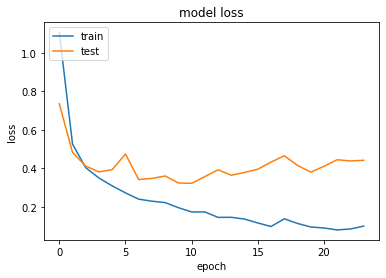

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 87.08%


## PREDICTIONS

In [35]:
preds = model.predict(X_test, 
                         batch_size=32, 
                         verbose=1)

preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (encoder.inverse_transform((abc)))

813/813 [==============================] - 0s 130us/step


In [36]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1).astype(int).flatten()
actualvalues = (encoder.inverse_transform((actual)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)
finaldf.head()

,actualvalues,predictedvalues
0,male_negative,male_negative
1,male_negative,male_positive
2,male_positive,male_positive
3,female_neutral,female_neutral
4,male_negative,male_negative


In [37]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_negative,397
female_neutral,109
female_positive,99
male_negative,124
male_neutral,53
male_positive,31


In [38]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_negative,400
female_neutral,110
female_positive,93
male_negative,125
male_neutral,49
male_positive,36


## PICKLE MODEL

In [40]:
import pickle
pickle.dump(model, open('pickles/model_emotionmf.p','wb'))
pickle.dump(encoder, open('pickles/encoder_emotionmf.p','wb'))
pickle.dump(scaler, open('pickles/scaler_emotionmf.p','wb'))

In [34]:
# pickle_model = pickle.load(open('model.p','rb'))